In [1]:
!pip install us

   ---------------------------------------- 0.0/212.1 kB ? eta -:--:--
   ----- ---------------------------------- 30.7/212.1 kB 1.3 MB/s eta 0:00:01
   --------------------- ------------------ 112.6/212.1 kB 1.3 MB/s eta 0:00:01
   ------------------------------------ --- 194.6/212.1 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 212.1/212.1 kB 1.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import us
import numpy as np

# 1. Load data into Data frame from Sqlite

In [4]:
# Path to your SQLite database
db_path = '../data/US.sqlite'

conn = sqlite3.connect(db_path)

query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query, conn)

print("Available Tables in Database:")
print(tables['name'].tolist())

# Dictionary to store DataFrames for each table
dataframes = {}

for table_name in tables['name']:
    try:
        df = pd.read_sql_query(f'SELECT * FROM "{table_name}"', conn)

        safe_table_name = table_name.replace(' ', '_')
        dataframes[safe_table_name] = df

        print(f"Loaded table '{table_name}' into DataFrame as '{safe_table_name}'")

    except Exception as e:
        print(f"Failed to process table {table_name}: {e}")

# Close connection
conn.close()

Available Tables in Database:
['USPoliceViolence', 'Hate Crimes']
Loaded table 'USPoliceViolence' into DataFrame as 'USPoliceViolence'
Loaded table 'Hate Crimes' into DataFrame as 'Hate_Crimes'


## 2.1 Stat and Data transformation

In [5]:
dataframes['USPoliceViolence']['State'] = dataframes['USPoliceViolence']['State'].apply(lambda x: us.states.lookup(x).name if us.states.lookup(x) else 'Unknown')


In [6]:
dataframes['USPoliceViolence'].isnull().sum()

Victim's age                                                                       0
Victim's gender                                                                    0
Victim's race                                                                      0
Date of Incident (month/day/year)                                                  0
City                                                                               0
State                                                                              0
Zipcode                                                                            0
Agency responsible for death                                                       0
Cause of death                                                                     0
Criminal Charges?                                                                  0
Symptoms of mental illness?                                                        0
Alleged Weapon (Source: WaPo and Review of Cases Not Included in 

# Convert the column to datetime format

In [7]:
dataframes['USPoliceViolence']['Date of Incident (month/day/year)'] = pd.to_datetime(
    dataframes['USPoliceViolence']['Date of Incident (month/day/year)'],
    errors='coerce'
)


# Filter rows for incidents between 2013 and 2020

In [8]:
dataframes['Hate_Crimes'] = dataframes['Hate_Crimes'][
    (dataframes['Hate_Crimes']['DATA_YEAR'] >= 2013) &
    (dataframes['Hate_Crimes']['DATA_YEAR'] <= 2020)
]


In [9]:
dataframes['USPoliceViolence'] = dataframes['USPoliceViolence'][
    (dataframes['USPoliceViolence']['Date of Incident (month/day/year)'].dt.year >= 2013) &
    (dataframes['USPoliceViolence']['Date of Incident (month/day/year)'].dt.year <= 2020)
]


In [10]:
dataframes['Hate_Crimes'].shape

(108836, 19)

## 2.2 Stat and Data transformation - Hate Crimes

In [11]:
dataframes['Hate_Crimes'] = dataframes['Hate_Crimes'].drop(columns=['ORI', 'STATE_ABBR',"DIVISION_NAME", "REGION_NAME", "POPULATION_GROUP_CODE", "POPULATION_GROUP_DESC", "MULTIPLE_OFFENSE","MULTIPLE_BIAS" ])

In [12]:
dataframes['Hate_Crimes'].columns

Index(['DATA_YEAR', 'STATE_NAME', 'INCIDENT_DATE', 'TOTAL_OFFENDER_COUNT',
       'OFFENDER_RACE', 'VICTIM_COUNT', 'OFFENSE_NAME',
       'TOTAL_INDIVIDUAL_VICTIMS', 'LOCATION_NAME', 'BIAS_DESC',
       'VICTIM_TYPES'],
      dtype='object')

# 3 Analysis

# 3.1 Hate_Crimes

In [13]:
dataframes['Hate_Crimes'].head(5)

,DATA_YEAR,STATE_NAME,INCIDENT_DATE,TOTAL_OFFENDER_COUNT,OFFENDER_RACE,VICTIM_COUNT,OFFENSE_NAME,TOTAL_INDIVIDUAL_VICTIMS,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES
0,2013,Alaska,2013-02-15 00:00:00.000000,1,Unknown,1,Aggravated Assault,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual
1,2013,Alaska,2013-03-01 00:00:00.000000,1,White,2,Intimidation,2.0,Highway/Road/Alley/Street/Sidewalk,Anti-American Indian or Alaska Native,Individual
2,2013,Alaska,2013-06-07 00:00:00.000000,4,White,1,Burglary/Breaking & Entering,1.0,Residence/Home,Anti-Black or African American,Individual
3,2013,Alaska,2013-06-17 00:00:00.000000,1,White,1,Simple Assault,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual
4,2013,Alaska,2013-06-20 00:00:00.000000,1,White,1,Intimidation,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual


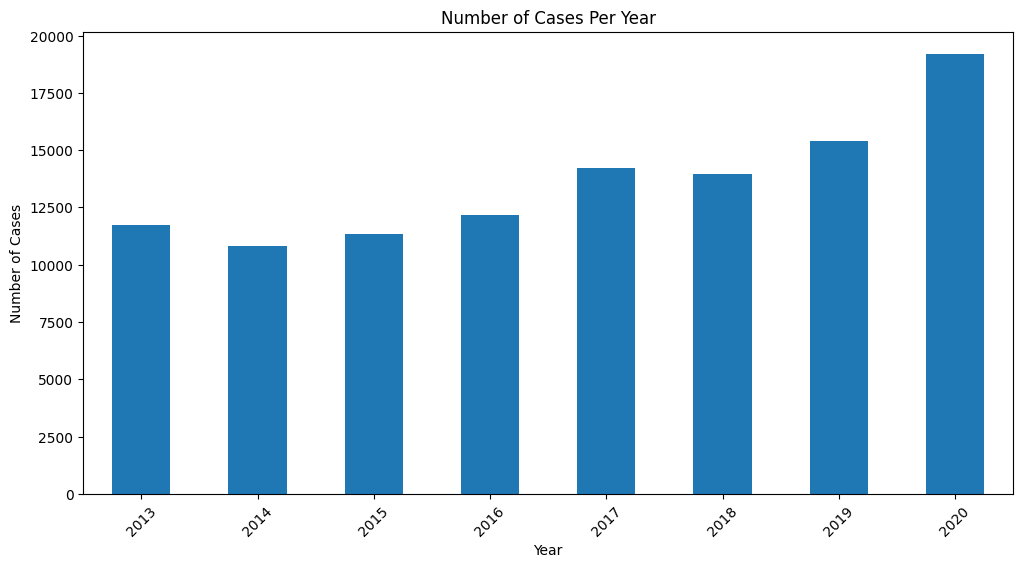

In [16]:
# Aggregate cases by Year
cases_per_year = dataframes['Hate_Crimes'].groupby('DATA_YEAR').size()

# Plot Cases per Year
plt.figure(figsize=(12, 6))
cases_per_year.plot(kind='bar')
plt.title('Number of Cases Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.show()

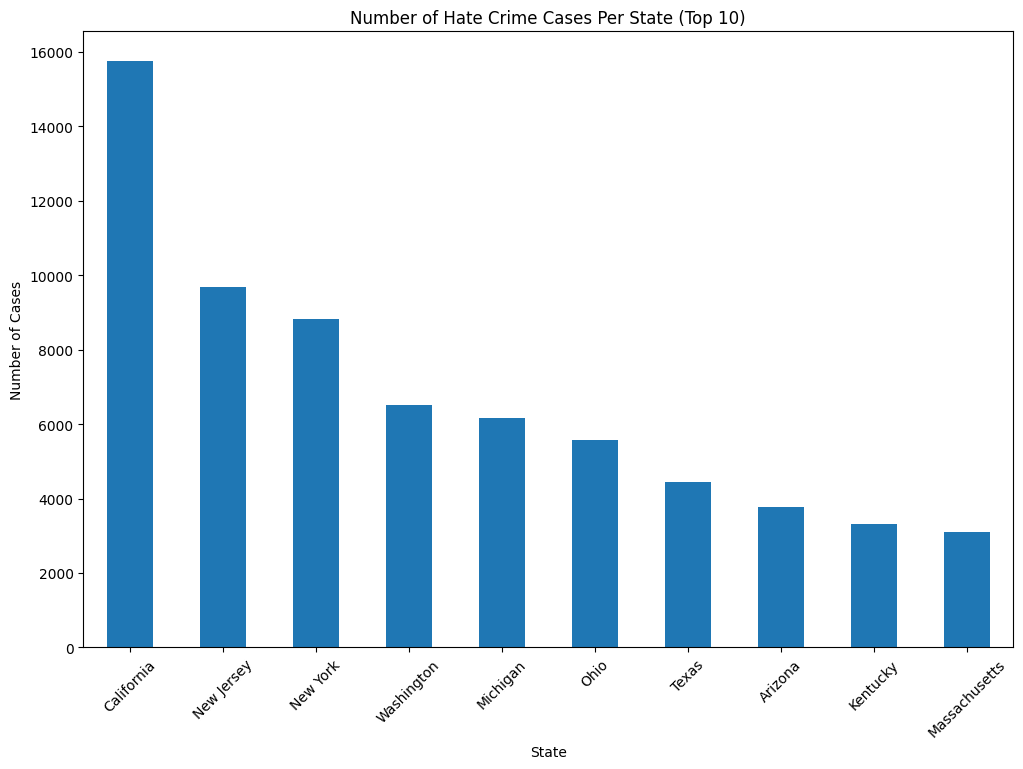

In [17]:
# Aggregate cases by State
cases_per_state = dataframes['Hate_Crimes'].groupby('STATE_NAME').size().sort_values(ascending=False).head(10)

# Plot Cases per State
plt.figure(figsize=(12, 8))
cases_per_state.plot(kind='bar')
plt.title('Number of Hate Crime Cases Per State (Top 10)')
plt.xlabel('State')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.show()

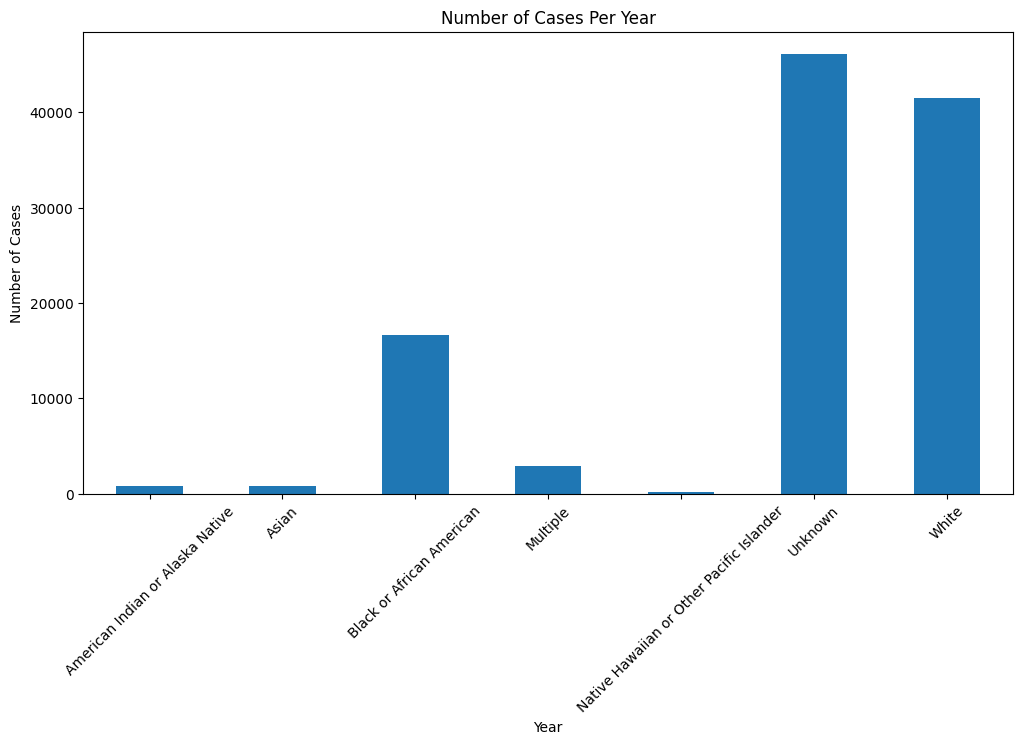

In [18]:
# Aggregate cases by Race
cases_per_year = dataframes['Hate_Crimes'].groupby('OFFENDER_RACE').size()

# Plot Cases per Year
plt.figure(figsize=(12, 6))
cases_per_year.plot(kind='bar')
plt.title('Number of Cases Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.show()

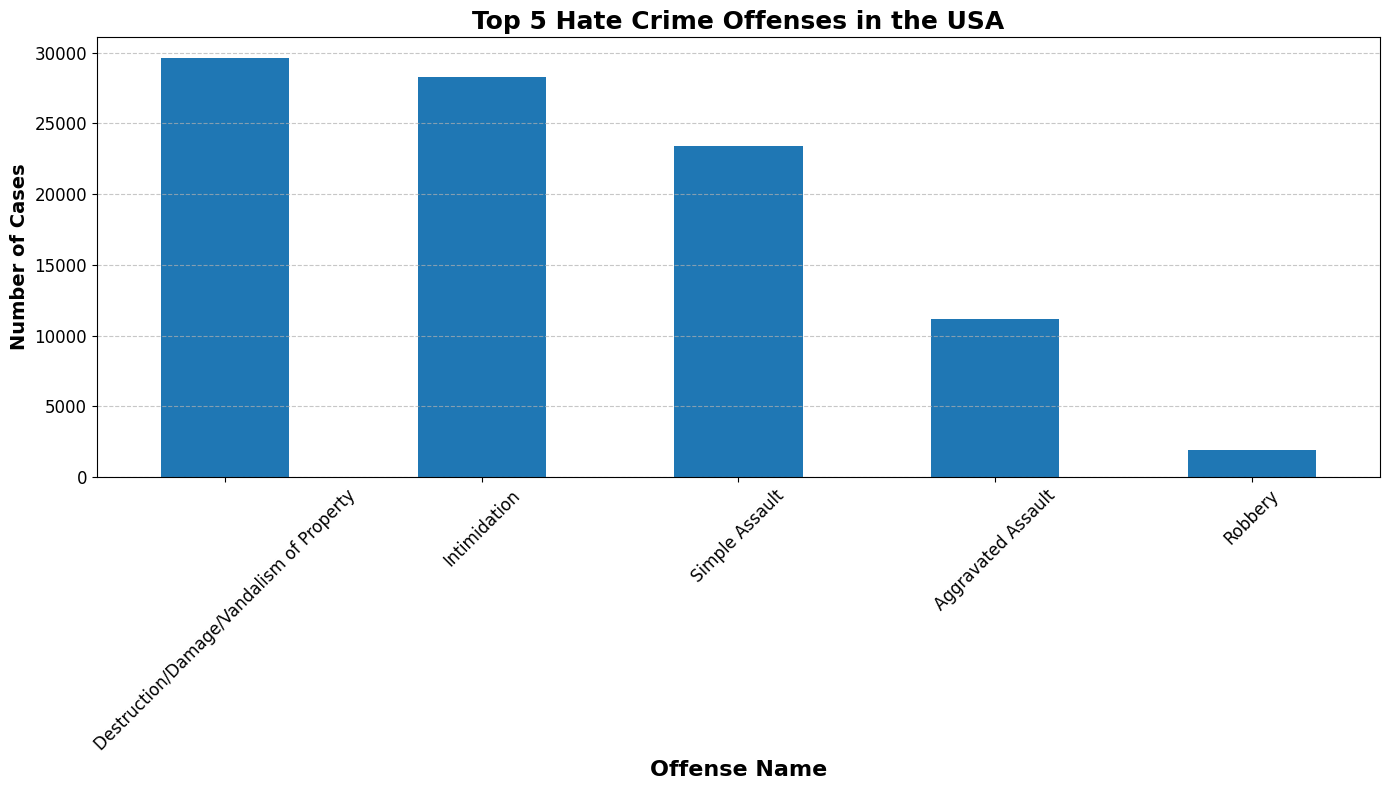

In [19]:
# Aggregate cases by OFFENSE_NAME
cases = dataframes['Hate_Crimes'].groupby('OFFENSE_NAME').size().nlargest(5)

# Plot Cases per Year
plt.figure(figsize=(14, 8))
cases.plot(kind='bar')

# Set title and labels with larger font sizes
plt.title('Top 5 Hate Crime Offenses in the USA', fontsize=18, fontweight='bold')
plt.xlabel('Offense Name', fontsize=16, fontweight='bold')
plt.ylabel('Number of Cases', fontsize=14, fontweight='bold')

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


# 3.2 USPoliceViolence

In [21]:
dataframes['USPoliceViolence'].drop(columns=["City", "Zipcode","Fleeing (Source: WaPo)" ]).head()

,Victim's age,Victim's gender,Victim's race,Date of Incident (month/day/year),State,Agency responsible for death,Cause of death,Criminal Charges?,Symptoms of mental illness?,Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database),Alleged Threat Level (Source: WaPo),Armed/Unarmed Status
772,Unknown,Male,Hispanic,2020-12-31,Florida,Miami Police Department,Gunshot,No known charges,No,gun,attack,Allegedly Armed
773,39,Male,White,2020-12-31,Texas,Beaumont Police Department,Gunshot,No known charges,Yes,gun,attack,Allegedly Armed
774,63,Male,Unknown race,2020-12-31,Indiana,Marshall County Sheriff's Department,Gunshot,No known charges,No,vehicle,attack,Vehicle
775,23,Male,Black,2020-12-30,Minnesota,Minneapolis Police Department,Gunshot,No known charges,No,gun,attack,Allegedly Armed
776,37,Male,White,2020-12-30,Kansas,Wichita Police Department,Gunshot,No known charges,No,gun,attack,Allegedly Armed


In [22]:
dataframes['USPoliceViolence'].columns

Index(['Victim's age', 'Victim's gender', 'Victim's race',
       'Date of Incident (month/day/year)', 'City', 'State', 'Zipcode',
       'Agency responsible for death', 'Cause of death', 'Criminal Charges?',
       'Symptoms of mental illness?',
       'Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database)',
       'Alleged Threat Level (Source: WaPo)', 'Fleeing (Source: WaPo)',
       'Armed/Unarmed Status'],
      dtype='object')

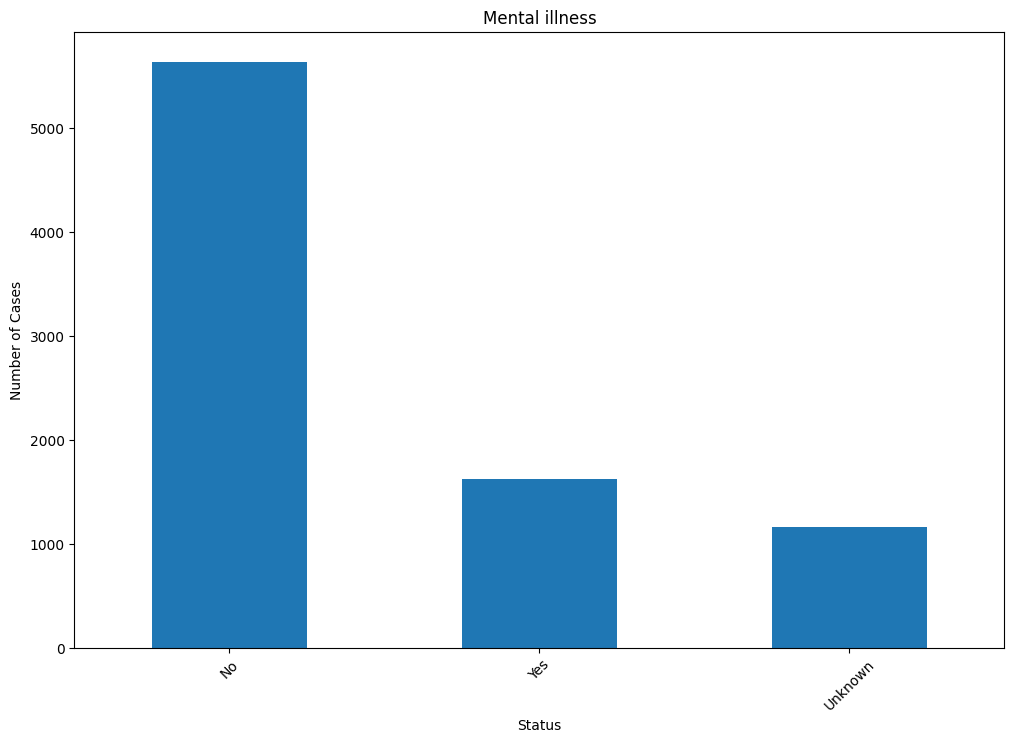

In [25]:
cases_per_state = dataframes['USPoliceViolence'].groupby('Symptoms of mental illness?').size().sort_values(ascending=False).head(3)

# Plot Cases per State
plt.figure(figsize=(12, 8))
cases_per_state.plot(kind='bar')
plt.title('Mental illness')
plt.xlabel('Status')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.show()

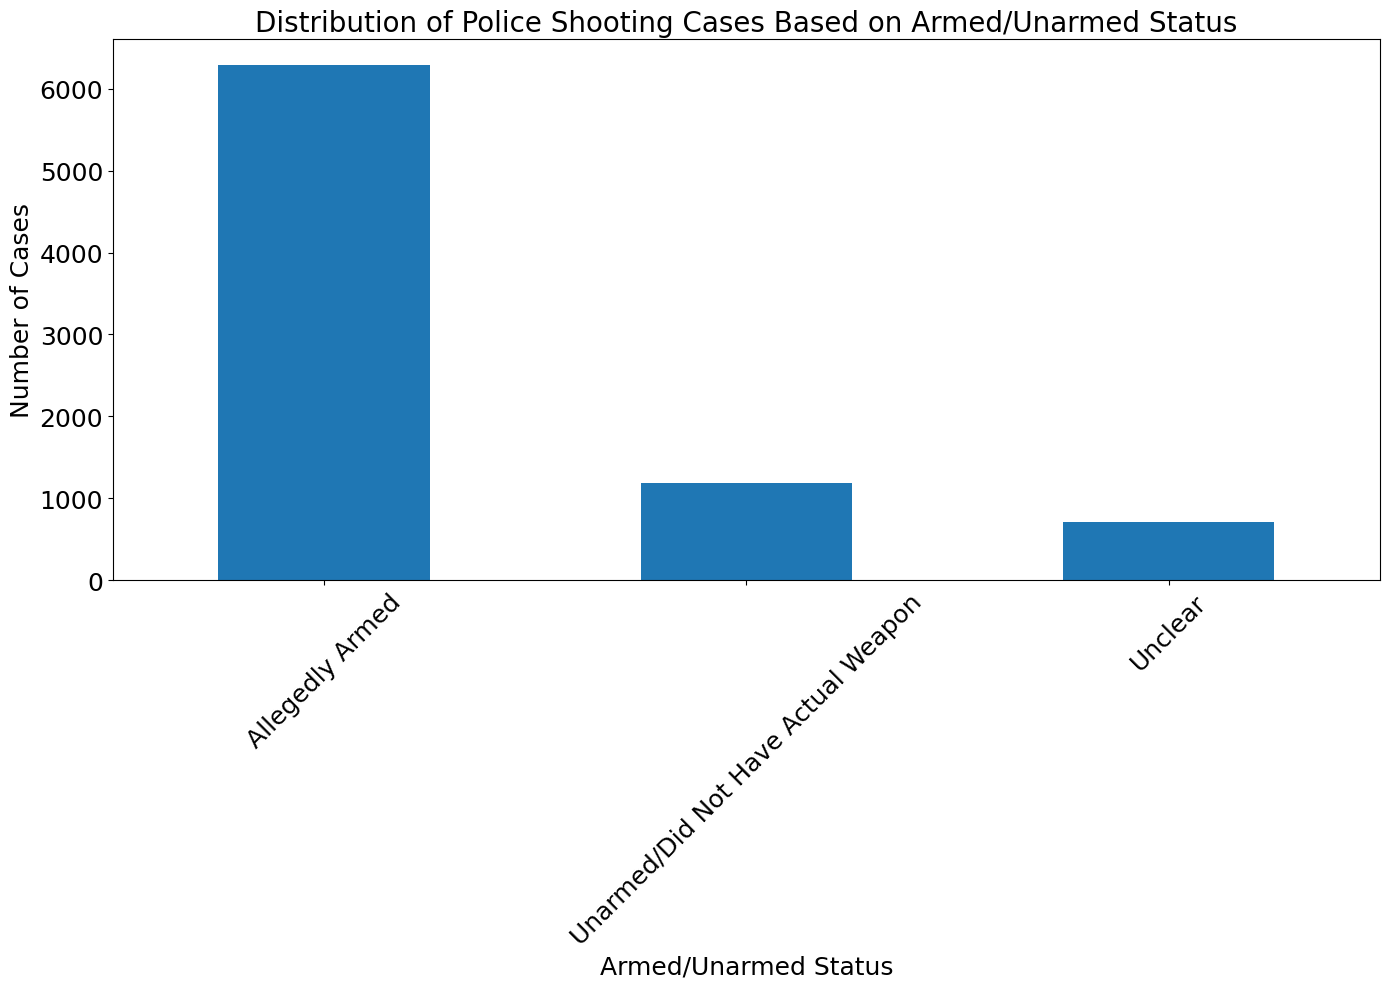

In [30]:
# Aggregate cases by 'Armed/Unarmed Status'
cases_per_state = dataframes['USPoliceViolence'].groupby('Armed/Unarmed Status').size().sort_values(ascending=False).head(3)

# Plot Cases by Armed/Unarmed Status
plt.figure(figsize=(14, 10))
cases_per_state.plot(kind='bar')

# Update Title and Labels
plt.title('Distribution of Police Shooting Cases Based on Armed/Unarmed Status', fontsize=20)
plt.xlabel('Armed/Unarmed Status', fontsize=18)
plt.ylabel('Number of Cases', fontsize=18)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)

# Display the Plot
plt.tight_layout()
plt.savefig('arm.png', dpi=300)

plt.show()


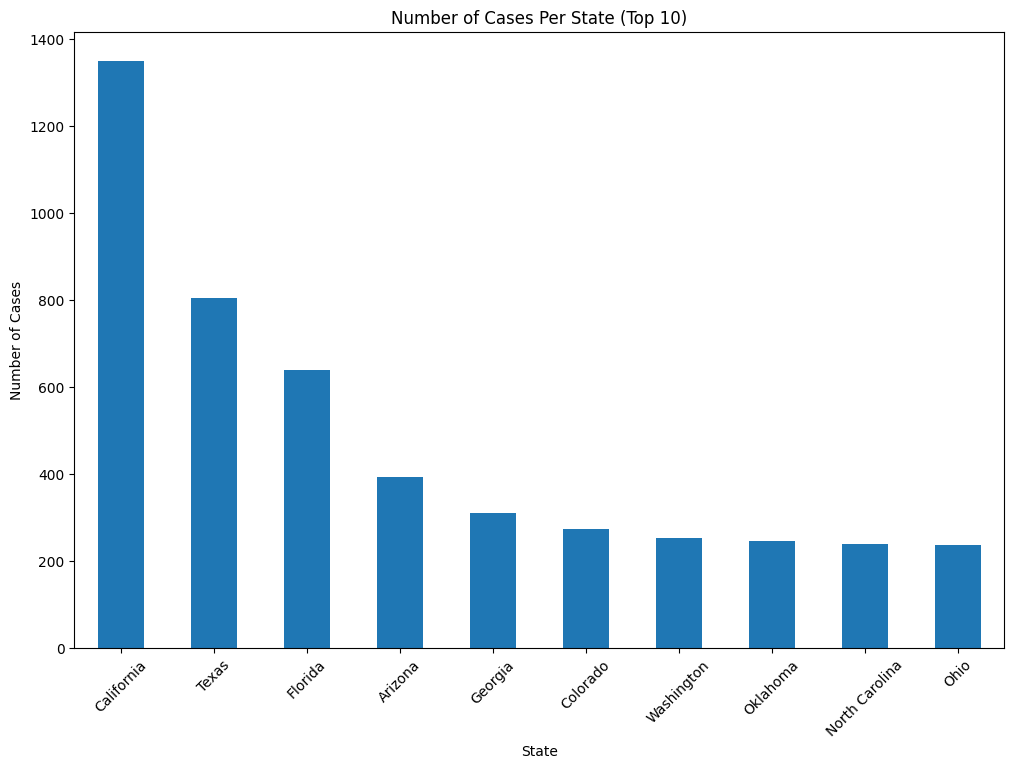

In [31]:
# Aggregate cases by State
cases_per_state = dataframes['USPoliceViolence'].groupby('State').size().sort_values(ascending=False).head(10)

# Plot Cases per State
plt.figure(figsize=(12, 8))
cases_per_state.plot(kind='bar')
plt.title('Number of Cases Per State (Top 10)')
plt.xlabel('State')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.show()

# Group

In [32]:

# Aggregate cases by State for both DataFrames
cases_df1 = dataframes['USPoliceViolence'].groupby('State').size().sort_values(ascending=False)
cases_df2 = dataframes['Hate_Crimes'].groupby('STATE_NAME').size().sort_values(ascending=False)

# Combine both series into one DataFrame for comparison
combined_df = pd.DataFrame({
    'USPoliceViolence': cases_df1,
    'Hate_Crimes': cases_df2
}).fillna(0)  # Fill missing states with 0


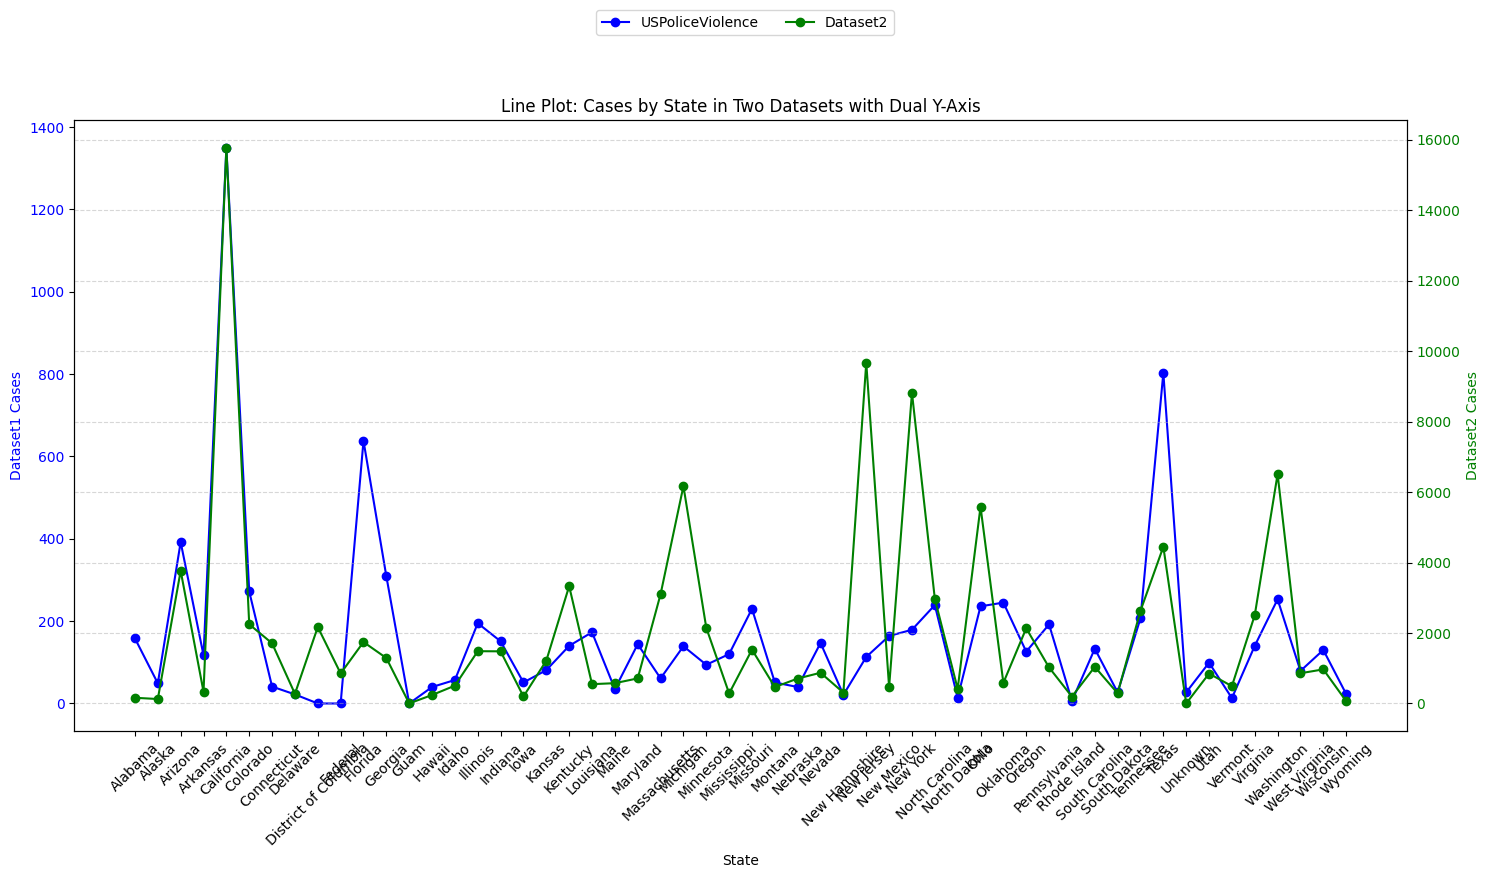

In [33]:

fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot Dataset 1 on Primary Y-Axis (Left)
ax1.plot(combined_df.index, combined_df['USPoliceViolence'], marker='o', color='b', label='USPoliceViolence')
ax1.set_xlabel('State')
ax1.set_ylabel('Dataset1 Cases', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(range(len(combined_df.index)))
ax1.set_xticklabels(combined_df.index, rotation=45)

# Create Secondary Y-Axis (Right)
ax2 = ax1.twinx()
ax2.plot(combined_df.index, combined_df['Hate_Crimes'], marker='o', color='g', label='Dataset2')
ax2.set_ylabel('Dataset2 Cases', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Add Legends
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

# Title and Grid
plt.title('Line Plot: Cases by State in Two Datasets with Dual Y-Axis')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [34]:
# Get Top 10 States from Each DataFrame
top_10_states_df1 = cases_df1.head(10)
top_10_states_df2 = cases_df2.head(10)

In [35]:
top_10_states_df1

State
California        1349
Texas              803
Florida            638
Arizona            392
Georgia            309
Colorado           272
Washington         253
Oklahoma           245
North Carolina     239
Ohio               236
dtype: int64

In [36]:
top_10_states_df2

STATE_NAME
California       15764
New Jersey        9672
New York          8818
Washington        6510
Michigan          6170
Ohio              5584
Texas             4448
Arizona           3766
Kentucky          3330
Massachusetts     3102
dtype: int64

In [37]:
# Extract state names as sets
top_10_set_df1 = set(top_10_states_df1.index)
top_10_set_df2 = set(top_10_states_df2.index)

# Find matches and differences
common_states = top_10_set_df1.intersection(top_10_set_df2)
only_in_df1 = top_10_set_df1 - top_10_set_df2
only_in_df2 = top_10_set_df2 - top_10_set_df1

# Print results
print("✅ Common States in Top 10 of Both Datasets:")
print(common_states)

print("\n🔹 States Only in 'USPoliceViolence' Top 10:")
print(only_in_df1)

print("\n🔹 States Only in 'AnotherDataset' Top 10:")
print(only_in_df2)

print(f"\n🔗 Total Number of Matching States: {len(common_states)}")


✅ Common States in Top 10 of Both Datasets:
{'Texas', 'California', 'Arizona', 'Washington', 'Ohio'}

🔹 States Only in 'USPoliceViolence' Top 10:
{'Florida', 'Oklahoma', 'Colorado', 'Georgia', 'North Carolina'}

🔹 States Only in 'AnotherDataset' Top 10:
{'Kentucky', 'New York', 'Massachusetts', 'New Jersey', 'Michigan'}

🔗 Total Number of Matching States: 5


In [41]:
!pip install matplotlib-venn

     ---------------------------------------- 0.0/40.3 kB ? eta -:--:--
     -------------------------------------- 40.3/40.3 kB 639.1 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for matplotlib-venn: filename=matplotlib_venn-1.1.1-py3-none-any.whl size=45396 sha256=8c4d5d389944dcc94909d189d7e6aabe08a667f52f990cec34e65675058dbec4
  Stored in directory: c:\users\badho\appdata\local\pip\cache\wheels\08\28\f0\0a3240d632a27df6da04d2888a6b058c37e1cbbb425ec5d2cc
Successfully built matplotlib-venn



[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


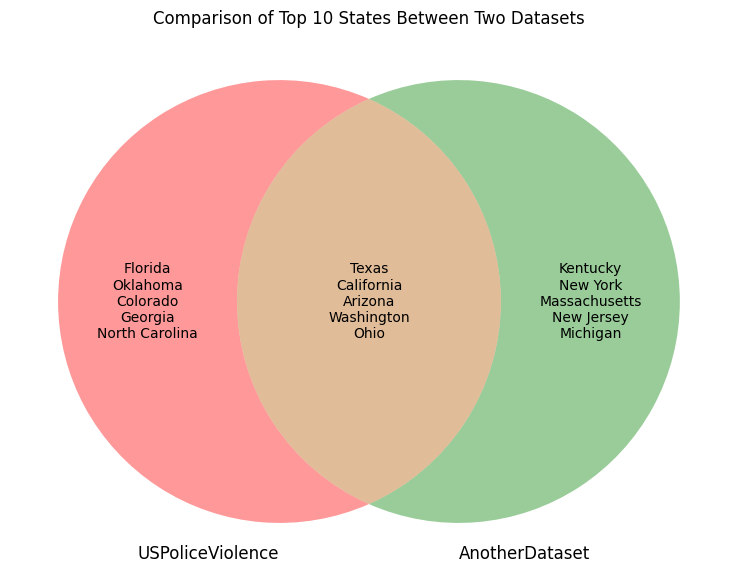

In [44]:
from matplotlib_venn import venn2

# Prepare sets
top_10_set_df1 = set(top_10_states_df1.index)
top_10_set_df2 = set(top_10_states_df2.index)

# Create Venn Diagram
plt.figure(figsize=(10, 7))
venn = venn2([top_10_set_df1, top_10_set_df2],
             set_labels=('USPoliceViolence', 'AnotherDataset'))

# Add Labels
venn.get_label_by_id('10').set_text('\n'.join(top_10_set_df1 - top_10_set_df2))
venn.get_label_by_id('01').set_text('\n'.join(top_10_set_df2 - top_10_set_df1))
venn.get_label_by_id('11').set_text('\n'.join(top_10_set_df1 & top_10_set_df2))

# Title
plt.title('Comparison of Top 10 States Between Two Datasets')
plt.show()


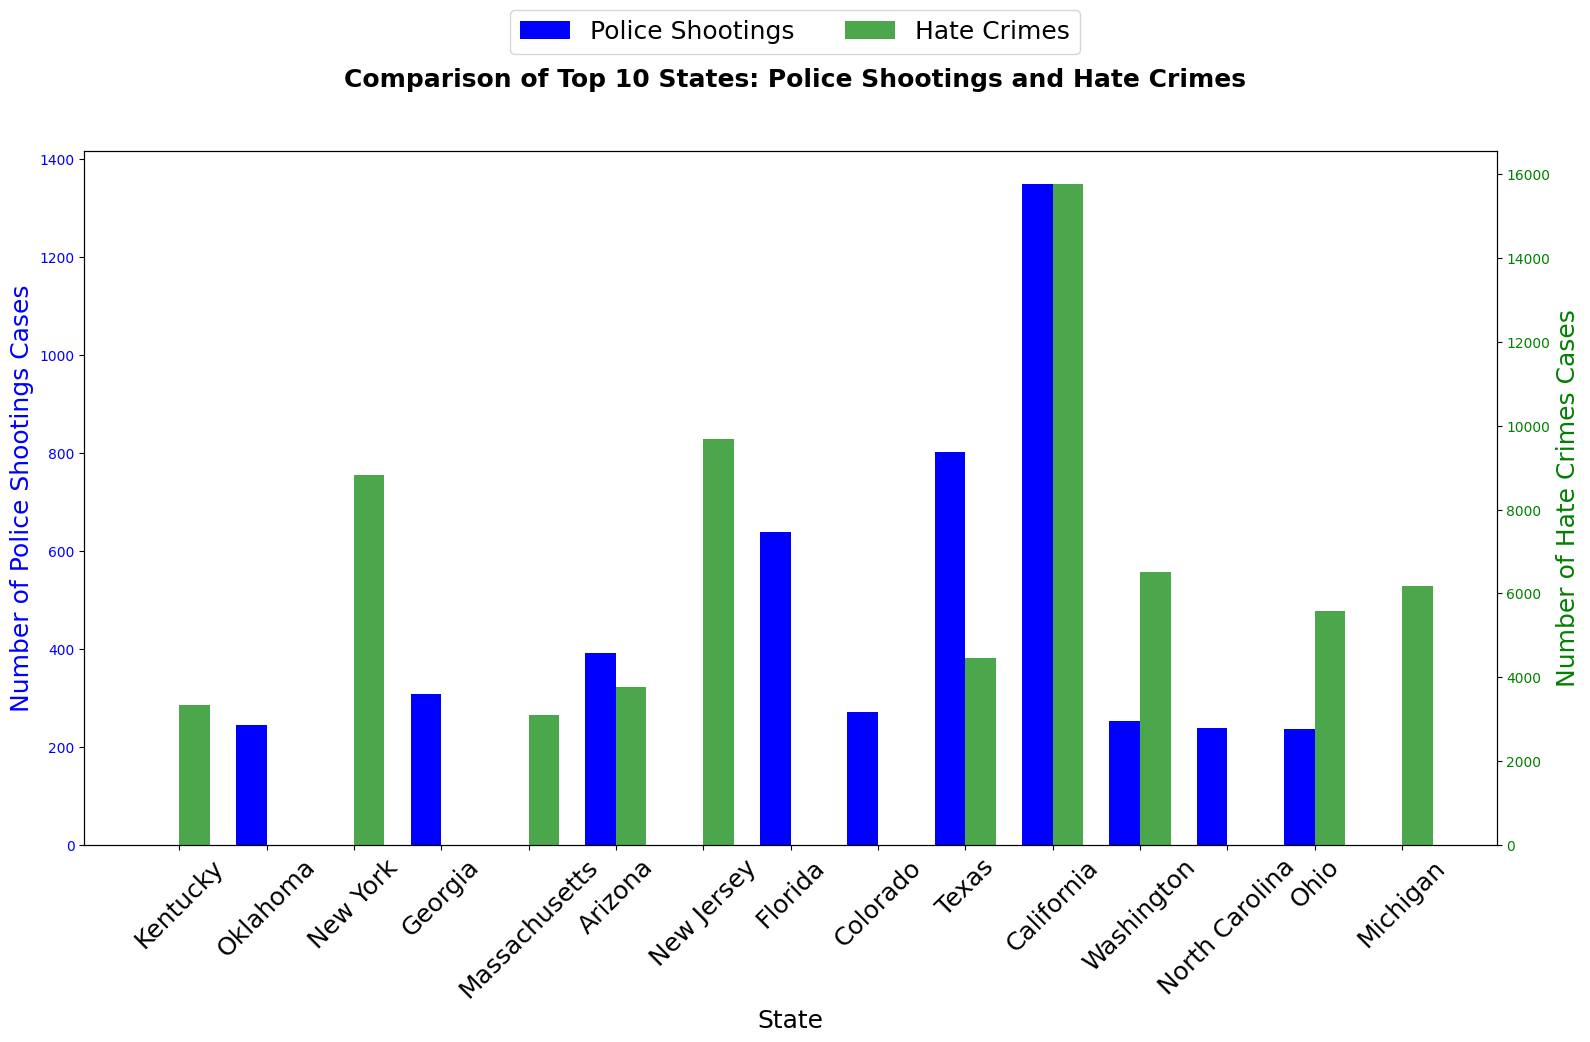

In [51]:

# Combine Top 10 States
common_states = set(top_10_states_df1.index) | set(top_10_states_df2.index)
combined_top10_df = pd.DataFrame({
    'USPoliceViolence': [top_10_states_df1.get(state, 0) for state in common_states],
    'Hate_Crimes': [top_10_states_df2.get(state, 0) for state in common_states]
}, index=list(common_states))

x = np.arange(len(combined_top10_df.index))
width = 0.35

fig, ax1 = plt.subplots(figsize=(16, 10))

bars1 = ax1.bar(x - width/2, combined_top10_df['USPoliceViolence'], width, label='Police Shootings', color='b')
ax1.set_ylabel('Number of Police Shootings Cases', fontsize=18, color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xlabel('State', fontsize=18)
ax1.set_xticks(x)
ax1.set_xticklabels(combined_top10_df.index, rotation=45, fontsize=18)

ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, combined_top10_df['Hate_Crimes'], width, label='Hate Crimes', color='g', alpha=0.7)
ax2.set_ylabel('Number of Hate Crimes Cases', fontsize=18, color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Add Title
fig.suptitle('Comparison of Top 10 States: Police Shootings and Hate Crimes', fontsize=18, fontweight='bold')

# Add Legends
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=18)

# Adjust Layout
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('top10.png', dpi=300)

plt.show()


In [52]:
# Aggregate cases by State for both DataFrames
cases_df1 = dataframes['USPoliceViolence'].groupby('State').size()
cases_df2 = dataframes['Hate_Crimes'].groupby('STATE_NAME').size()

# Ensure both datasets have all states (fill missing states with 0)
all_states = set(cases_df1.index).union(set(cases_df2.index))
cases_df1 = cases_df1.reindex(all_states, fill_value=0).sort_index()
cases_df2 = cases_df2.reindex(all_states, fill_value=0).sort_index()

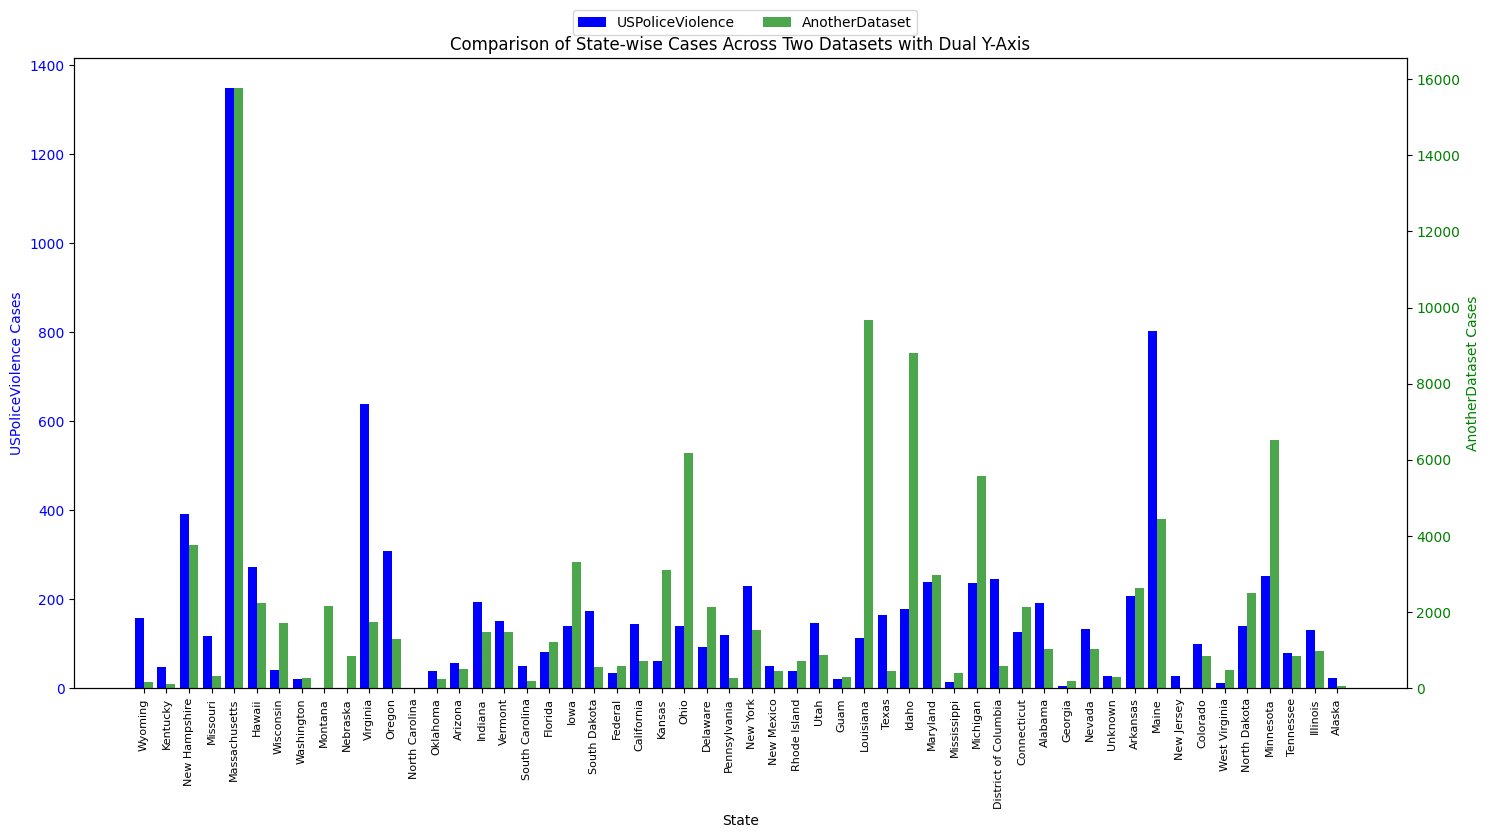

In [53]:
# Plot Setup
fig, ax1 = plt.subplots(figsize=(15, 8))

x = np.arange(len(all_states))  # Label positions
width = 0.4  # Bar width

# Primary Y-axis for Dataset 1
bars1 = ax1.bar(x - width/2, cases_df1, width, label='USPoliceViolence', color='b')
ax1.set_xlabel('State')
ax1.set_ylabel('USPoliceViolence Cases', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(x)
ax1.set_xticklabels(all_states, rotation=90, fontsize=8)

# Secondary Y-axis for Dataset 2
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, cases_df2, width, label='AnotherDataset', color='g', alpha=0.7)
ax2.set_ylabel('AnotherDataset Cases', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Add Legends
fig.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)

# Title
plt.title('Comparison of State-wise Cases Across Two Datasets with Dual Y-Axis')

# Display Plot
plt.show()


In [54]:
# Aggregate cases by State for both DataFrames
cases_df1 = dataframes['USPoliceViolence'].groupby('State').size()
cases_df2 = dataframes['Hate_Crimes'].groupby('STATE_NAME').size()

# Ensure both datasets have all states (fill missing states with 0)
all_states = set(cases_df1.index).union(set(cases_df2.index))
cases_df1 = cases_df1.reindex(all_states, fill_value=0).sort_index()
cases_df2 = cases_df2.reindex(all_states, fill_value=0).sort_index()

In [55]:
# Combine into a Single DataFrame
combined_df = pd.DataFrame({
    'USPoliceViolence': cases_df1,
    'Hate_Crimes': cases_df2
}).fillna(0)

# Verify Combined DataFrame
print(combined_df.head())


            USPoliceViolence  Hate_Crimes
Alabama                  158          162
Alaska                    49          126
Arizona                  392         3766
Arkansas                 117          332
California              1349        15764


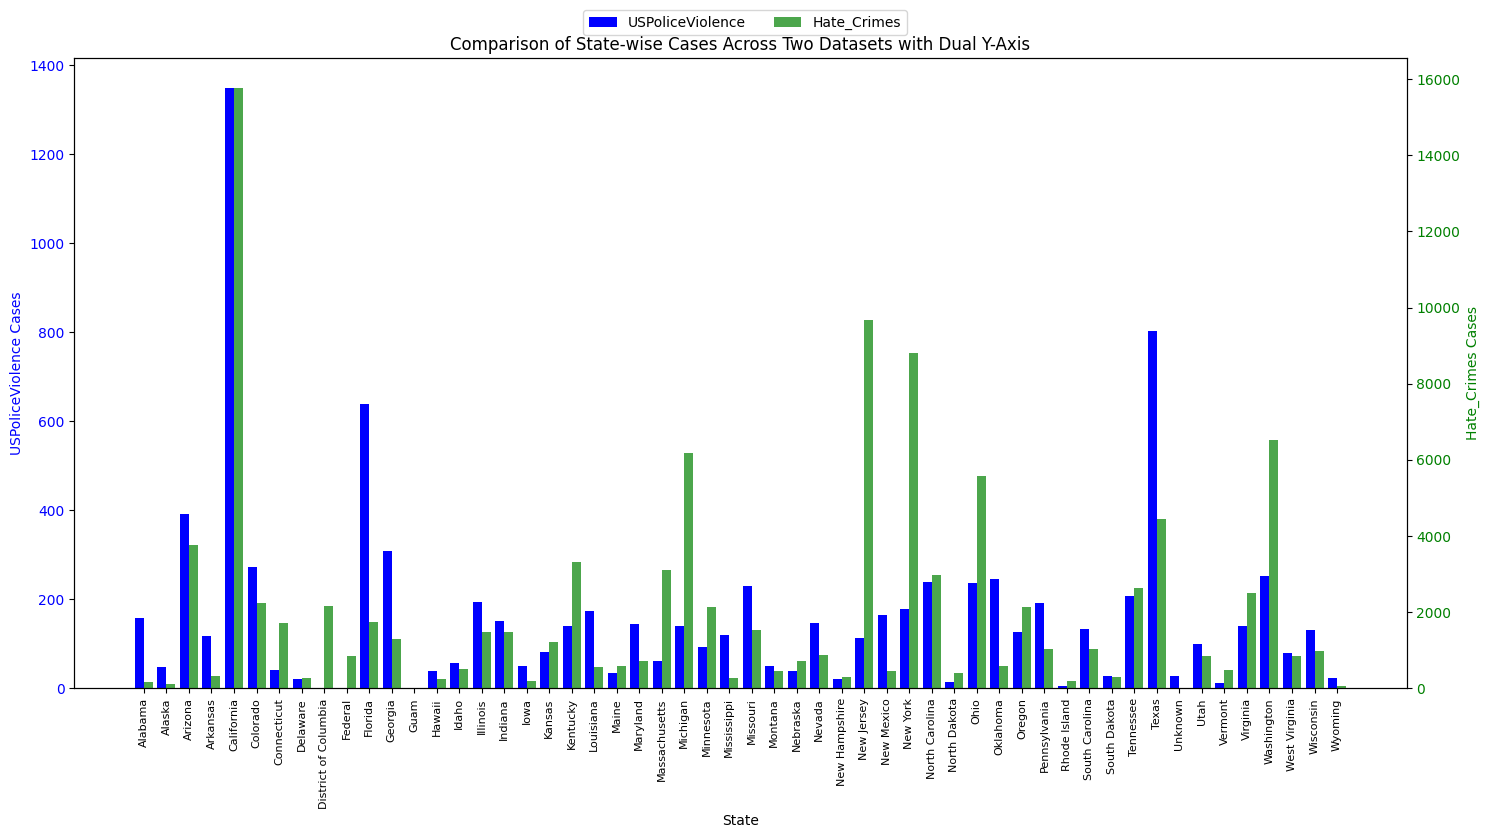

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Setup
fig, ax1 = plt.subplots(figsize=(15, 8))

x = np.arange(len(combined_df.index))  # Label positions
width = 0.4  # Bar width

# Primary Y-axis for Dataset 1
bars1 = ax1.bar(x - width/2, combined_df['USPoliceViolence'], width, label='USPoliceViolence', color='b')
ax1.set_xlabel('State')
ax1.set_ylabel('USPoliceViolence Cases', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(x)
ax1.set_xticklabels(combined_df.index, rotation=90, fontsize=8)

# Secondary Y-axis for Dataset 2
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, combined_df['Hate_Crimes'], width, label='Hate_Crimes', color='g', alpha=0.7)
ax2.set_ylabel('Hate_Crimes Cases', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Add Legends
fig.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)

# Title
plt.title('Comparison of State-wise Cases Across Two Datasets with Dual Y-Axis')

# Display Plot
plt.show()


In [57]:
dataframes['USPoliceViolence']['Date of Incident (month/day/year)'] = pd.to_datetime(
    dataframes['USPoliceViolence']['Date of Incident (month/day/year)'], errors='coerce'
)
dataframes['Hate_Crimes']['INCIDENT_DATE'] = pd.to_datetime(
    dataframes['Hate_Crimes']['INCIDENT_DATE'], errors='coerce'
)

# Extract Year
dataframes['USPoliceViolence']['Year'] = dataframes['USPoliceViolence']['Date of Incident (month/day/year)'].dt.year
dataframes['Hate_Crimes']['Year'] = dataframes['Hate_Crimes']['INCIDENT_DATE'].dt.year

# Group by Year and Count Rows
yearly_counts_uspv = dataframes['USPoliceViolence'].groupby('Year').size().reset_index(name='USPoliceViolence')
yearly_counts_hc = dataframes['Hate_Crimes'].groupby('Year').size().reset_index(name='Hate_Crimes')

# Merge Both DataFrames on Year
yearly_counts = pd.merge(yearly_counts_uspv, yearly_counts_hc, on='Year', how='outer').fillna(0)
yearly_counts = yearly_counts.sort_values(by='Year')
print(yearly_counts)


   Year  USPoliceViolence  Hate_Crimes
0  2013              1087        11737
1  2014              1049        10822
2  2015              1102        11326
3  2016              1070        12153
4  2017              1091        14208
5  2018              1144        13981
6  2019              1096        15408
7  2020              1126        19201


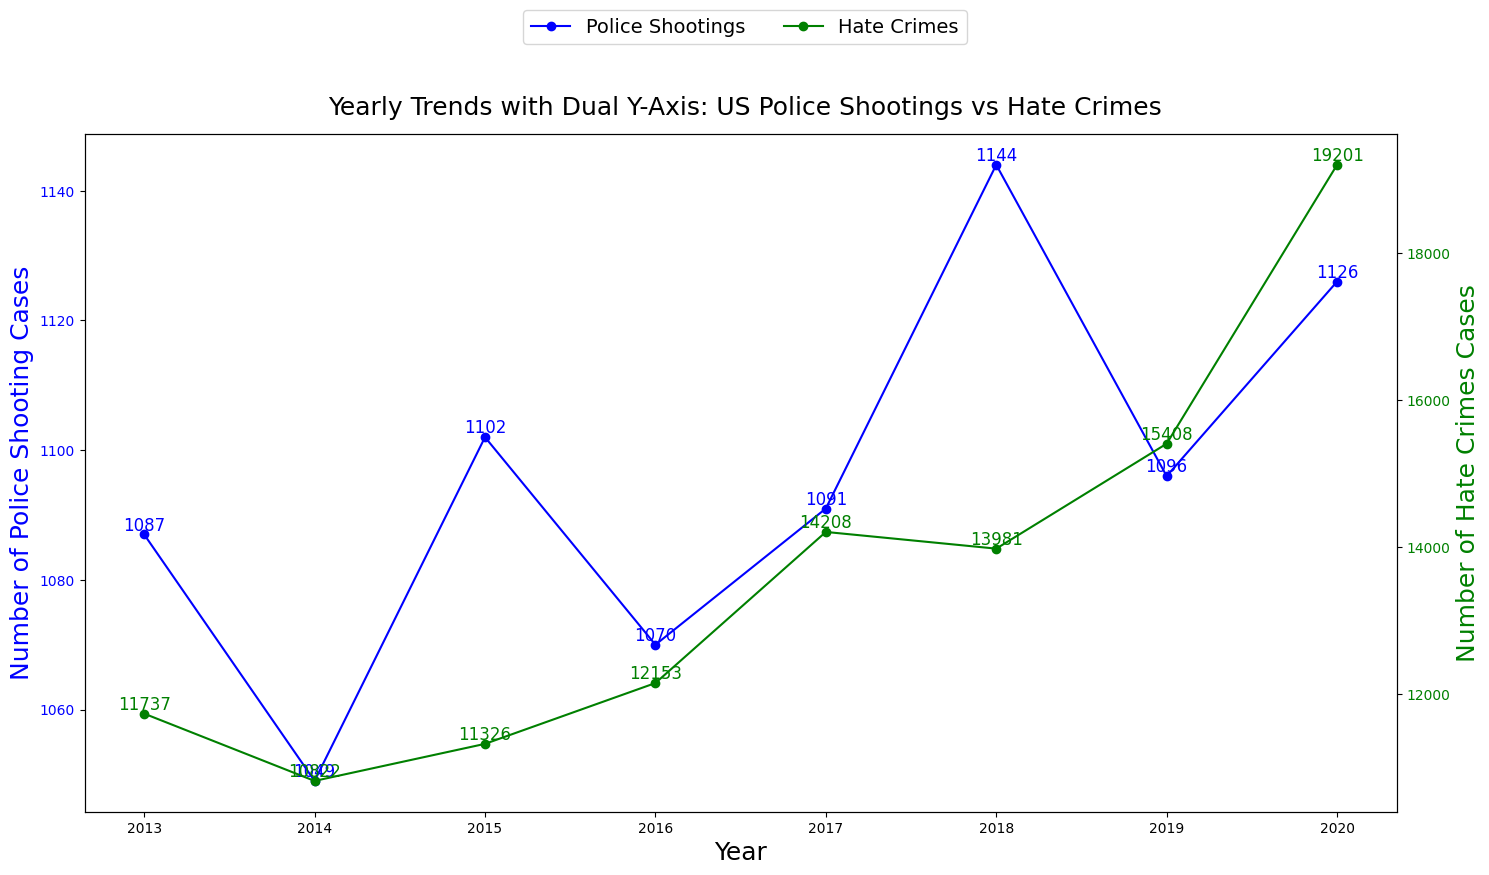

In [74]:

# Plot Setup for yarly trend
fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.plot(yearly_counts['Year'], yearly_counts['USPoliceViolence'], marker='o', label='Police Shootings', color='b')
ax1.set_xlabel('Year', fontsize=18)
ax1.set_ylabel('Number of Police Shooting Cases', fontsize=18, color='b')
ax1.tick_params(axis='y', labelcolor='b')

for i, value in enumerate(yearly_counts['USPoliceViolence']):
    ax1.text(
        yearly_counts['Year'].iloc[i],
        value,
        f'{int(value)}',
        ha='center',
        va='bottom',
        fontsize=12,
        color='b'
    )

ax2 = ax1.twinx()
ax2.plot(yearly_counts['Year'], yearly_counts['Hate_Crimes'], marker='o', label='Hate Crimes', color='g')
ax2.set_ylabel('Number of Hate Crimes Cases', fontsize=18, color='g')
ax2.tick_params(axis='y', labelcolor='g')

for i, value in enumerate(yearly_counts['Hate_Crimes']):
    ax2.text(
        yearly_counts['Year'].iloc[i],
        value,
        f'{int(value)}',
        ha='center',
        va='bottom',
        fontsize=12,
        color='g'
    )

# Add Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
fig.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.1),
    ncol=2,
    fontsize=14
)

# Title
fig.suptitle('Yearly Trends with Dual Y-Axis: US Police Shootings vs Hate Crimes', fontsize=18)

# Adjust Layout
plt.tight_layout()

plt.savefig("yearly.png", dpi=300, bbox_inches="tight")
plt.show()


In [75]:
# Count rows with explicit 'Unknown' or placeholders
unknown_state_count_explicit = dataframes['USPoliceViolence']['State'].str.strip().isin(['Unknown', 'N/A', '','0']).sum()
print(f"🔄 Rows with Explicit Unknown State Values: {unknown_state_count_explicit}")

🔄 Rows with Explicit Unknown State Values: 27


In [76]:
dataframes['USPoliceViolence']['State'].unique()

array(['Florida', 'Texas', 'Indiana', 'Minnesota', 'Kansas', 'Idaho',
       'Pennsylvania', 'Georgia', 'New York', 'California',
       'South Carolina', 'Colorado', 'Arizona', 'Massachusetts', 'Hawaii',
       'Oregon', 'Connecticut', 'Tennessee', 'New Hampshire', 'Ohio',
       'Illinois', 'Alabama', 'Alaska', 'Michigan', 'Maine', 'Washington',
       'North Carolina', 'New Mexico', 'Oklahoma', 'Utah', 'Montana',
       'West Virginia', 'Virginia', 'Delaware', 'Wisconsin',
       'Mississippi', 'Nevada', 'Missouri', 'Louisiana', 'Kentucky',
       'Nebraska', 'Maryland', 'Wyoming', 'South Dakota', 'Vermont',
       'Iowa', 'Unknown', 'North Dakota', 'New Jersey', 'Arkansas',
       'Rhode Island'], dtype=object)

In [77]:
# Count rows with explicit 'Unknown' or placeholders
unknown_state_count_explicit = dataframes['Hate_Crimes']['STATE_NAME'].str.strip().isin(['Unknown', 'N/A', '','0']).sum()
print(f"🔄 Rows with Explicit Unknown State Values: {unknown_state_count_explicit}")

🔄 Rows with Explicit Unknown State Values: 0


In [78]:
dataframes['Hate_Crimes']['STATE_NAME'].unique()

array(['Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California',
       'Colorado', 'Connecticut', 'District of Columbia', 'Delaware',
       'Florida', 'Federal', 'Georgia', 'Guam', 'Hawaii', 'Iowa', 'Idaho',
       'Illinois', 'Indiana', 'Kansas', 'Kentucky', 'Louisiana',
       'Maryland', 'Maine', 'Michigan', 'Minnesota', 'Missouri',
       'Mississippi', 'Montana', 'Nebraska', 'North Carolina',
       'North Dakota', 'New Hampshire', 'New Jersey', 'New Mexico',
       'Nevada', 'New York', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Massachusetts', 'Utah', 'Virginia', 'Vermont',
       'Washington', 'Wisconsin', 'West Virginia', 'Wyoming'],
      dtype=object)

In [79]:

# Aggregate cases by State for both datasets
cases_df1 = dataframes['USPoliceViolence'].groupby('State').size().reset_index(name='USPoliceViolence')
cases_df2 = dataframes['Hate_Crimes'].groupby('STATE_NAME').size().reset_index(name='Hate_Crimes')

# Merge Both Aggregated DataFrames
combined_df = pd.merge(cases_df1, cases_df2, left_on='State', right_on='STATE_NAME', how='outer').fillna(0)

# Drop duplicate State column after merging
combined_df = combined_df.drop(columns=['STATE_NAME'])

# Sort and get bottom 15 states for each dataset
lowest_states_uspv = combined_df.sort_values(by='USPoliceViolence', ascending=True).head(10)
lowest_states_hc = combined_df.sort_values(by='Hate_Crimes', ascending=True).head(10)

# Find common states in both lists
common_low_states = set(lowest_states_uspv['State']).intersection(set(lowest_states_hc['State']))

# Display Results
print("✅ 15 States with the Lowest Rates in USPoliceViolence:")
print(lowest_states_uspv[['State', 'USPoliceViolence']])

print("\n✅ 15 States with the Lowest Rates in Hate_Crimes:")
print(lowest_states_hc[['State', 'Hate_Crimes']])

print("\n🔗 ✅ Common States with Low Rates in Both Datasets:")
print(common_low_states)


✅ 15 States with the Lowest Rates in USPoliceViolence:
            State  USPoliceViolence
53              0               0.0
51              0               0.0
52              0               0.0
38   Rhode Island               6.0
45        Vermont              13.0
33   North Dakota              14.0
28  New Hampshire              21.0
7        Delaware              22.0
50        Wyoming              23.0
43        Unknown              27.0

✅ 15 States with the Lowest Rates in Hate_Crimes:
           State  Hate_Crimes
43       Unknown          0.0
53             0          2.0
50       Wyoming         66.0
1         Alaska        126.0
0        Alabama        162.0
38  Rhode Island        194.0
14          Iowa        198.0
10        Hawaii        240.0
7       Delaware        274.0
23   Mississippi        284.0

🔗 ✅ Common States with Low Rates in Both Datasets:
{0, 'Wyoming', 'Delaware', 'Rhode Island', 'Unknown'}


In [80]:
# Filter rows where STATE_NAME is 'Texas'
texas_hate_crimes = dataframes['Hate_Crimes'][dataframes['Hate_Crimes']['STATE_NAME'] == 'Delaware']

# Count occurrences of each unique value in 'BIAS_DESC'
texas_bias_counts = texas_hate_crimes['BIAS_DESC'].value_counts().reset_index()
texas_bias_counts.columns = ['BIAS_DESC', 'Count']

# Display the top rows to verify
print(texas_bias_counts.head())


                            BIAS_DESC  Count
0      Anti-Black or African American    116
1                     Anti-Gay (Male)     42
2                         Anti-Jewish     22
3                          Anti-White     18
4  Anti-Other Race/Ethnicity/Ancestry     14


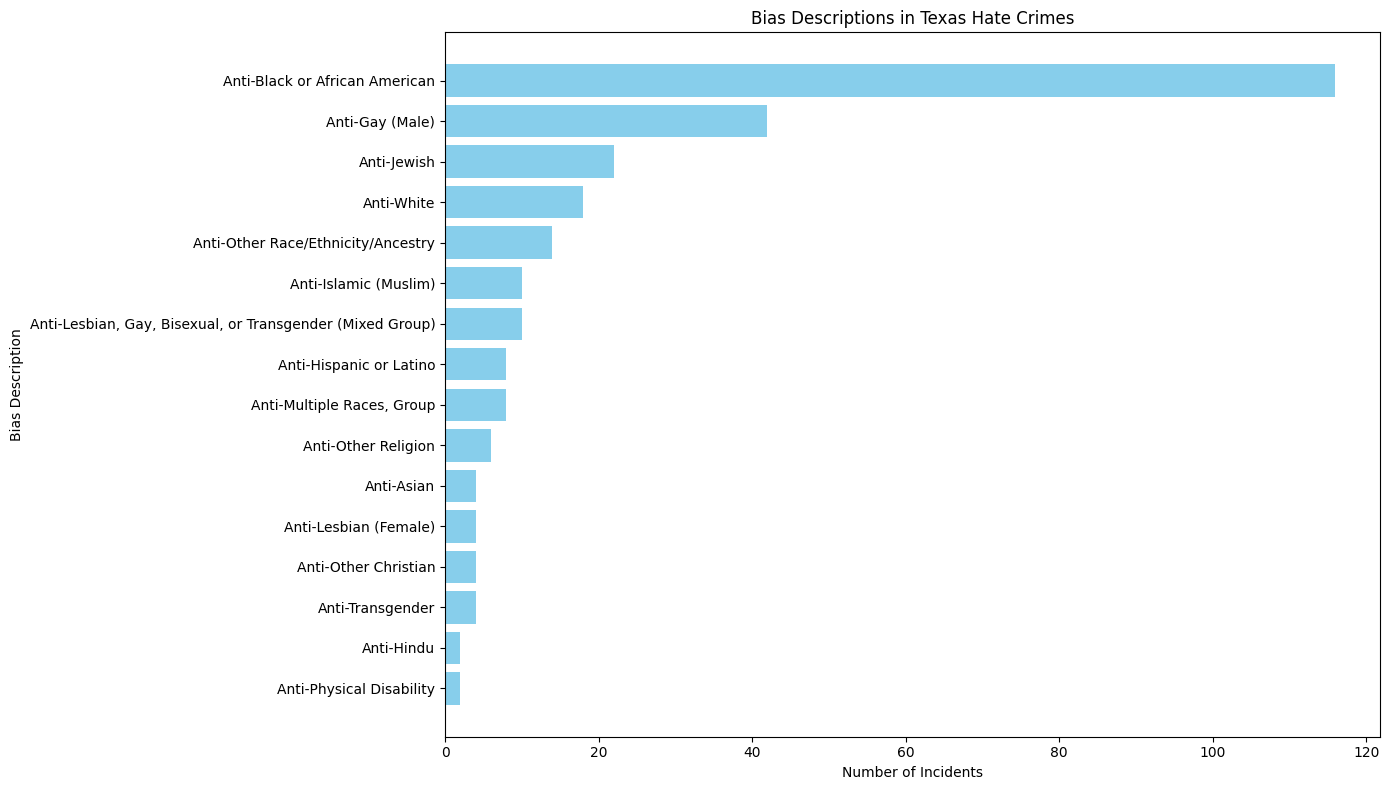

In [81]:
# Plot as a bar chart
plt.figure(figsize=(14, 8))
plt.barh(texas_bias_counts['BIAS_DESC'], texas_bias_counts['Count'], color='skyblue')

# Customize Plot
plt.title('Bias Descriptions in Texas Hate Crimes')
plt.xlabel('Number of Incidents')
plt.ylabel('Bias Description')
plt.gca().invert_yaxis()  # Invert Y-axis for better readability
plt.tight_layout()

# Show Plot
plt.show()


In [82]:
# Aggregate data by state
crime_by_state = dataframes['Hate_Crimes'].groupby('STATE_NAME').size().reset_index(name='CrimeInstances')
violence_by_state = dataframes['USPoliceViolence'].groupby('State').size().reset_index(name='PoliceViolence')

# Merge datasets on State
combined_df = pd.merge(crime_by_state, violence_by_state, left_on='STATE_NAME', right_on='State', how='inner')

# Drop duplicate State column if exists
combined_df.drop(columns=['State'], inplace=True)

In [83]:
# Calculate correlation
correlation = combined_df['CrimeInstances'].corr(combined_df['PoliceViolence'])
print(f"🔗 Correlation Coefficient: {correlation:.2f}")
combined_df


🔗 Correlation Coefficient: 0.67


,STATE_NAME,CrimeInstances,PoliceViolence
0,Alabama,162,158
1,Alaska,126,49
2,Arizona,3766,392
3,Arkansas,332,117
4,California,15764,1349
5,Colorado,2248,272
6,Connecticut,1708,41
7,Delaware,274,22
8,Florida,1744,638
9,Georgia,1290,309


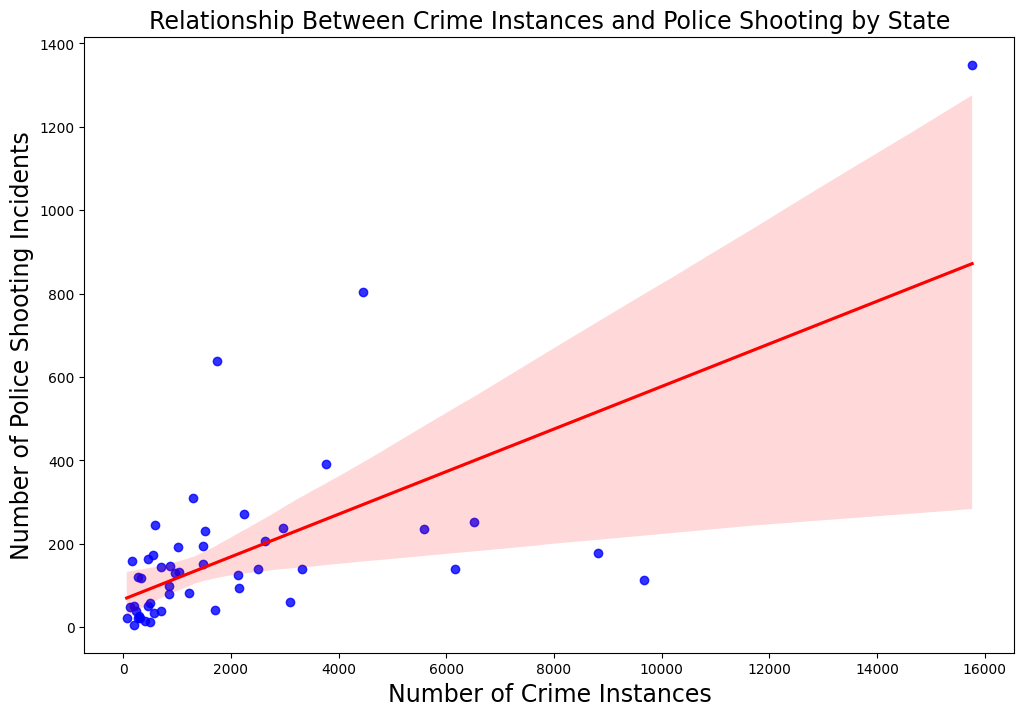

In [84]:
import seaborn as sns

# Assuming combined_df contains the data for Crime Instances and Police Violence
plt.figure(figsize=(12, 8))

# Scatter plot with regression line
sns.regplot(
    x=combined_df['CrimeInstances'],
    y=combined_df['PoliceViolence'],
    scatter_kws={'color': 'blue'},
    line_kws={'color': 'red'},
    ci=95
)

# Add titles and labels
plt.title('Relationship Between Crime Instances and Police Shooting by State', fontsize = 17)
plt.xlabel('Number of Crime Instances', fontsize = 17)
plt.ylabel('Number of Police Shooting Incidents', fontsize = 17)

# Show the plot
plt.show()


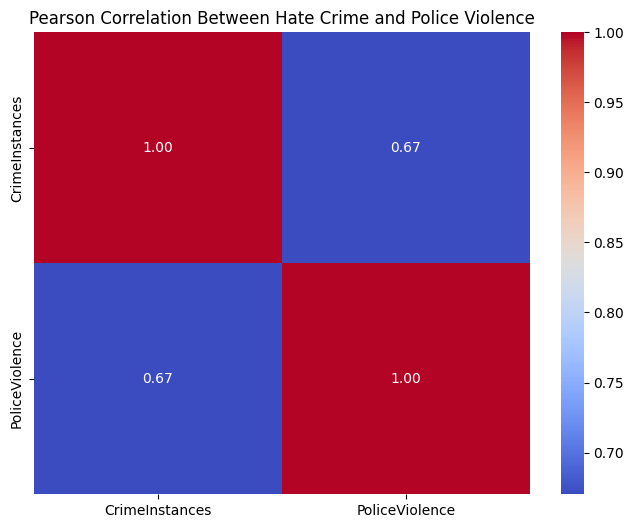

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate Pearson Correlation
correlation = combined_df[['CrimeInstances', 'PoliceViolence']].corr(method='pearson')

# Plot Pearson Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    cbar=True
)
plt.title('Pearson Correlation Between Hate Crime and Police Violence')
plt.show()
